In [78]:
import numpy as np
np.random.seed(2)

import matplotlib.pyplot as plt
%matplotlib inline


from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# convert to one-hot-encoding
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# Error Level Analysis (ELA)

In [13]:
# initial preparation for ELA (error level analysis) module
from PIL import Image, ImageChops, ImageEnhance
from pylab import *
import os
import itertools
import re

# functions of path images
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

# functions of ELA
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

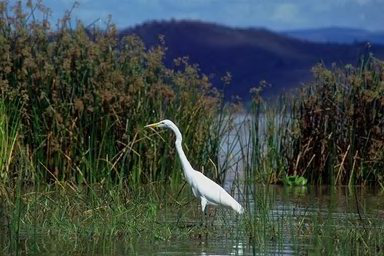

In [14]:
# sample of Real image
real_image_Au = '/content/drive/MyDrive/casia/Real/Au_ani_00002.jpg'
Image.open(real_image_Au)

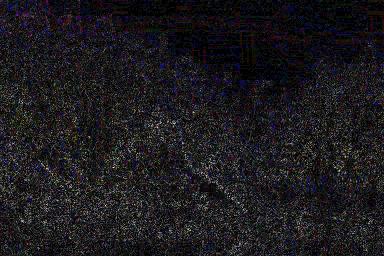

In [15]:
# After processed with ELA
convert_to_ela_image(real_image_Au, 80)

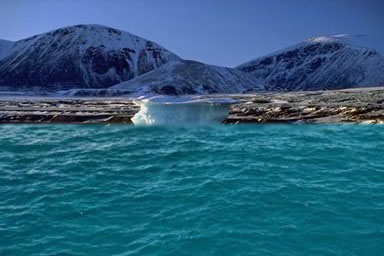

In [16]:
# Edited image or fake image
fake_image_Tp = '/content/drive/MyDrive/casia/Fake/Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg'
Image.open(fake_image_Tp)

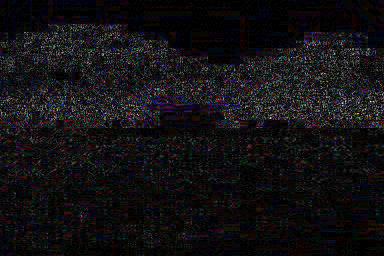

In [17]:
# compare the result of two ELA which are Fake and real
# based on our observation, we able to detect the ELA result of the REAL and FAKE images
# the background of the image clearly unvisible and some of object in the images slightly visible, but the zebra visible
convert_to_ela_image(fake_image_Tp, 80)

# Preparation of Datasets 

In [18]:
# Dataset preparation
image_size = (256, 256)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 80).resize(image_size)).flatten() / 255.0

X = [] # ELA converted images
Y = [] # 0 = fake; 1 = real

In [19]:
# this function will extracts some random images from the Au (7492 cut down till 1000 ) and Tp (5124 cut down till 1000)
# to balance out the dataset to avoid more images in one class folder for causing model bias
# ideally 1000 images per class at minimum
import random

path = '/content/drive/MyDrive/casia/Real'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:1000]
Y = Y[:1000]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
1000 1000


In [20]:
path = '/content/drive/MyDrive/casia/Fake'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
3064 3064


In [21]:
# convert to one-hot-encoding
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator

X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 256, 256, 3)

In [22]:
# train test split with 80:20 ratio
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

2451 2451
613 613


# MesoNet

In [79]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)
image_dimensions = {'height':256, 'width':256, 'channels':3}

In [80]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, X):
        return self.model.predict(X)
    
    def fit(self, X, Y):
        return self.model.train_on_batch(X, Y)
    
    def get_accuracy(self, X, Y):
        return self.model.test_on_batch(X, Y)
    
    def load(self, path):
        self.model.load_weights(path)

In [81]:
# Create a MesoNet class using the Classifier

class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        X = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(X)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        Y = Flatten()(x4)
        y = Dropout(0.5)(Y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = X, outputs = y)

In [82]:
# Instantiate a MesoNet model with pretrained weights
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline
meso = Meso4()
meso.load('/content/drive/MyDrive/Meso4_DF')

In [83]:
# Prepare image data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    '/content/drive/MyDrive/casia',
    target_size=(128, 128),
    batch_size=1,
    class_mode='binary')

Found 12616 images belonging to 3 classes.


In [84]:
 # Checking class assignment
generator.class_indices

{'.ipynb_checkpoints': 0, 'Au': 1, 'Tp': 2}

In [85]:
from pathlib import Path

root_dir = '/content/drive/MyDrive/casia'
root = Path(root_dir)
# parent dir must not start with dot
for datafile in root.rglob('[!.]*/.ipynb_checkpoints.npy'):
  print(datafile)  # or np.load(datafile)

In [86]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Recreating generator after removing '.ipynb_checkpoints'
dataGenerator = ImageDataGenerator(rescale=1./255)

generator = dataGenerator.flow_from_directory(
    '/content/drive/MyDrive/casia',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

# Re-checking class assignment after removing it
generator.class_indices

Found 12616 images belonging to 3 classes.


{'.ipynb_checkpoints': 0, 'Au': 1, 'Tp': 2}

Predicted likelihood: 0.9952
Actual label: 1

Correct prediction: True


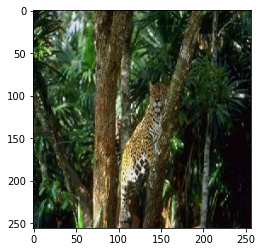

In [87]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [88]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [89]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

0  predictions completed.
1000  predictions completed.
2000  predictions completed.


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


3000  predictions completed.
4000  predictions completed.
5000  predictions completed.
6000  predictions completed.
7000  predictions completed.
8000  predictions completed.
9000  predictions completed.
10000  predictions completed.
11000  predictions completed.
12000  predictions completed.
All 12616 predictions completed


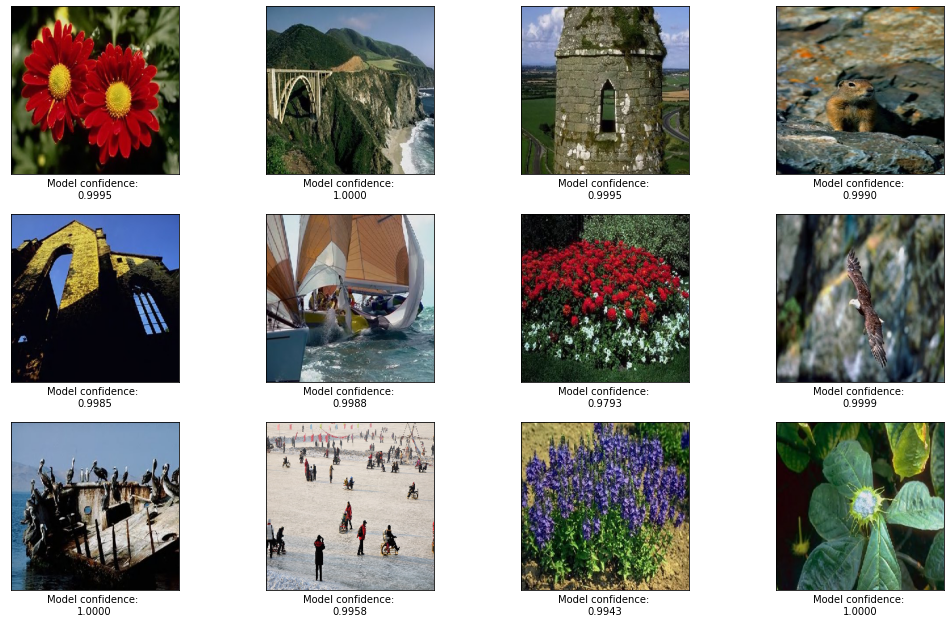

In [90]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

plotter(correct_real, correct_real_pred)

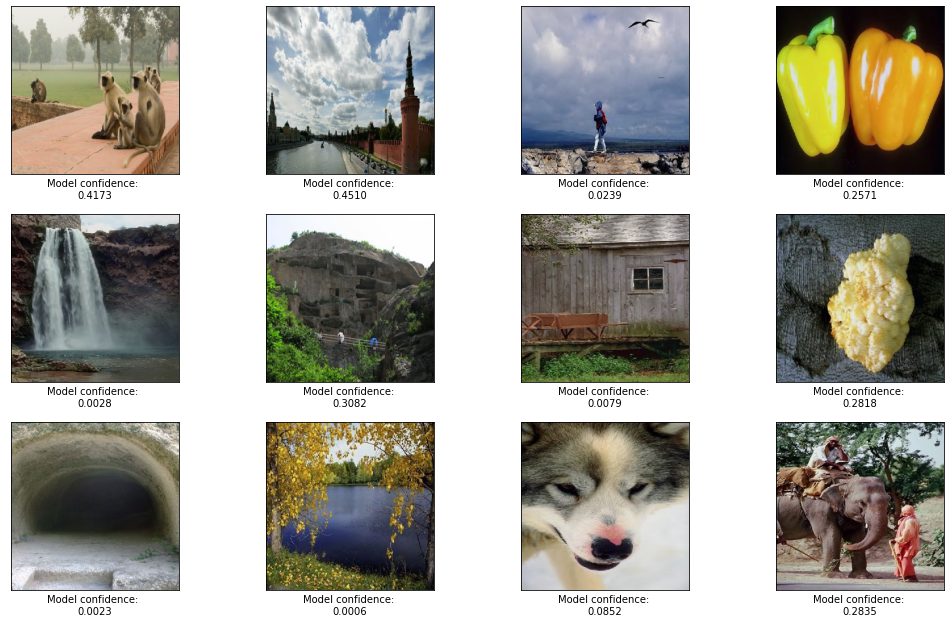

In [91]:
plotter(misclassified_real, misclassified_real_pred)